In [26]:
import os,sys,inspect
current_dir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parent_dir = os.path.dirname(current_dir)
sys.path.insert(0, parent_dir)

import time
import torch
import numpy as np
import random
import matplotlib.pyplot as plt
import json

import agent

from toolbox import get_word_ix, UniversalConstants, UniversalData, model_best_acc_detector, load_listener_model, load_speaker_model, curiosity

In [2]:
# Required for the functions defined here. They should be imported to toolbox when the function definitions move there.
import numpy as np
from toolbox import load_numpy

In [3]:
import torch.nn as nn
import torch.optim as optim

In [4]:
uc = UniversalConstants()
ud = UniversalData()

setting = 'random'
which_set = 'val'

# Overlapping Analysis

This notebook intends to do the steps below:

1. [Choose the most accurate random model](#best_random)
2. [Extract the choices on each epoch](#data_extraction)

## 1. Choose the most accurate `random` model <a name="best_random"></a>

In [5]:
# path to the loss_acc results to choose the best model
path_loss_acc = os.path.join('/home', 'u1270964', 'curiosity', 'loss_acc', 'unsupervised/')

In [6]:
# This definition should move to toolbox
def best_model_acc(_path_loss_acc, _agent, _setting, which_set, learning, mode='single'):
    if _agent == 'listener':
            _agent = 'li'
    elif _agent == 'speaker':
            _agent = 'sp'
    else:
        print("put either listener or speaker for agent.")
    
    if mode == 'single':
        
        _the_best = {'best_seed': 0,
                     'best_ep': 0,
                     'best_acc': 0.0}

        for _seed in uc.final_seeds:
            scores = load_numpy(_path_loss_acc, _agent, which_set, 'acc', 0.001, _setting, _seed)
            if max(scores) > _the_best['best_acc']:
                _the_best['best_seed'] = _seed
                _the_best['best_ep'] = scores.argmax() + 1
                _the_best['best_acc'] = scores[_the_best['best_ep'] - 1]
    
    elif mode == 'avg':
        _the_best = {'best_seed': 0,
                     'best_ep': 0,
                     'best_avg_acc': 0.0,
                     'top_acc': 0.0,
                     'min_acc': 0.0,
                     'scores': []}

        for _seed in uc.final_seeds:
            
            scores = load_numpy(_path_loss_acc, _agent, which_set, 'acc', 0.001, _setting, _seed)
            acc_avg = np.mean(scores)
            # acc_avg = np.average(scores, weights=np.arange(1,41))
            if acc_avg > _the_best['best_avg_acc']:
                _the_best['best_seed'] = _seed
                _the_best['best_ep'] = scores.argmax() + 1
                _the_best['best_avg_acc'] = acc_avg
                _the_best['top_acc'] = max(scores)
                _the_best['min_acc'] = min(scores)
                _the_best['scores'] = scores
    else:
        print('mode should be either \'single\' or \'avg\'.')

    return _the_best


-----------------------------------
The most accurate random model is:

Best Seed:		 456 
Avearge Accuracy:	 0.57 
---
Lowest Accuracy:	 0.30 
Highest Accuracy:	 0.66 
----------------------------------- 



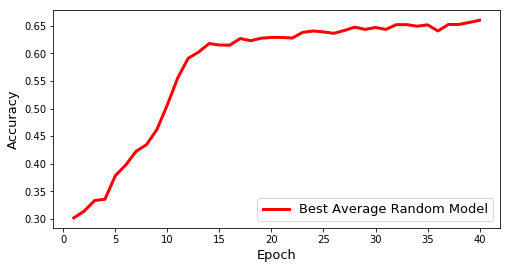

In [7]:
best_random_model = best_model_acc(path_loss_acc, 'listener', setting, which_set, uc.final_seeds, 'avg')

print('\n'+"-"*35+"\nThe most accurate random model is:\n\n"
      +"Best Seed:\t\t", best_random_model['best_seed'],
      "\nAvearge Accuracy:\t", format(best_random_model['best_avg_acc'], '.2f'),
      "\n---\nLowest Accuracy:\t", format(best_random_model['min_acc'], '.2f'),
      "\nHighest Accuracy:\t", format(best_random_model['top_acc'], '.2f'),
      '\n'+"-"*35,'\n')

figure = plt.figure(figsize=[8,4])
plt.plot(np.arange(1,41), best_random_model['scores'],
         label='Best Average Random Model', color="red", linewidth=3)
plt.legend(loc='lower right', fontsize=13)
plt.ylabel('Accuracy', fontsize=13)
plt.xlabel('Epoch', fontsize=13)
plt.show()

In [8]:
random.seed(a=best_random_model['best_seed'])

# setting torch seeds
torch.cuda.manual_seed(best_random_model['best_seed'])
torch.manual_seed(best_random_model['best_seed'])

np.random.seed(best_random_model['best_seed'])

## 2. Extract the choices of different curiosity metrics <a name"data_extraction"></a>

I will load the same model for 

_1. for each epoch:_
>1.1. load the model[epoch]

>1.2. for all img in val_split:
>>1.2.1. for each condition:
>>>1.2.1.1. record the choices

Should check:
    
- difference of train batch set and val batch set

In [9]:
def load_img(_dict_words_boxes, _ha_vggs_indices, _word_to_ix, img, _device, path_vgg):
    vggs = torch.load(path_vgg + img + ".pt").to(_device)  # Edit path
    # dict met obj ids als keys en een dictionary met words : '', bboxes :
    # n = 0
    bbox_indices = []
    words = []
    for obj in _dict_words_boxes[img]:  # For every object in this image
        words.append(get_word_ix(_word_to_ix, _dict_words_boxes[img][obj]["word"]))
        bbox_indices.append(_ha_vggs_indices[img][obj][0])
    visual_input = vggs[bbox_indices, :]
    language_input = torch.tensor(words, dtype=torch.long, device=_device)
    return language_input, visual_input

In [10]:
def curious_look(_dict_words_boxes, _ha_vggs_indices, _img, _setting, _word_to_ix, _device):
    language_input, scene = load_img(_dict_words_boxes, _ha_vggs_indices, _word_to_ix, _img, _device, uc.path_vgg)
    # repeat scene n_objects times as input to listener
    visual_input = scene.expand(scene.size()[0], scene.size()[0], scene.size()[1])
    curiosity_targets = torch.eye(visual_input.size()[0], dtype=torch.float, device=ud.device)
    # targets is simply 0, 1, ...., n because they are in order of appearance
    targets = torch.tensor([i for i in range(len(language_input))], dtype=torch.long, device=ud.device)
    # word guesses by child - use as attention over word embeddings
    word_guesses = speaker(visual_input, curiosity_targets, apply_softmax=False)
    # only keep most likely words
    words = torch.argmax(word_guesses, dim=1)
    # give these as input to listener
    object_guesses = listener(words, visual_input)
    curiosity_values = curiosity(curiosity_targets, object_guesses, _setting)
    max_curious = torch.argmax(curiosity_values)
    return max_curious

In [11]:
def pair_count(list_1, list_2):
    pair_check = []
    
    if len(list_1)==len(list_2):
        for _index in range(len(list_1)):
            if list_1[_index] == list_2[_index]:
                pair_check.append(1)
            else:
                pair_check.append(0)
    else:
        print("THE LISTS SHOUDL HAVE THE SAME LENGTH!")
    
    pair_count = pair_check.count(1)
    
    return {'count': pair_count, 'vec': pair_check}

In [12]:
def trip_count(list_1, list_2, list_3):
    trip_check = []
    
    if (len(list_1)==len(list_2)) and (len(list_2)==len(list_3)):
        for _index in range(len(list_1)):
            if (list_1[_index] == list_2[_index]) and (list_2[_index] == list_3[_index]):
                trip_check.append(1)
            else:
                trip_check.append(0)
    else:
        print("THE LISTS SHOUDL HAVE THE SAME LENGTH!")
    
    trip_count = trip_check.count(1)
    
    return {'count': trip_count, 'vec': trip_check}

In [13]:
trip_count([1,2,3,4], [4,2,3,4], [1,2,6,4])

{'count': 2, 'vec': [0, 1, 0, 1]}

In [14]:
def load_listener_models(path_models_folder, _word_to_ix, _device, setting: str = 'curious', epoch: int = 0, lr: float = 0.001,
                        seed: int = 123) -> agent.Listener:
    """
    Loads the listener model
    -----

    :param _word_to_ix:
    :type _word_to_ix:
    :param _device:
    :type _device:
    :param path_models_folder:
    :type path_models_folder:
    :param setting:
    :type setting:
    :param epoch:
    :type epoch:
    :param lr:
    :type lr:
    :param seed:
    :type seed:
    :return:
    :rtype:
    """
    path_wanted_model = os.path.join(path_models_folder, setting,
                                     'liModel_{}_{}_{}_ep{}.pth'.format(setting, lr, seed, epoch))

    uc = UniversalConstants()

    ntokens = len(_word_to_ix.keys())

    # initializing the model
    model = agent.Listener(uc.object_size, ntokens, uc.wordemb_size,
                           uc.att_hidden_size, nonlinearity=uc.nonlin).to(_device)
    # load state_dict to it
    checkpoint = torch.load(path_wanted_model)
    model.load_state_dict(checkpoint)
    print("\nModel's state_dict:")  # print the loaded state_dict
    for param_tensor in model.state_dict():
        print(param_tensor, "\t", model.state_dict()[param_tensor].size())
    print((('-' * 60) + '\n') * 2)

    return model

In [15]:
def load_speaker_models(path_models_folder, _word_to_ix, _device, setting: str = 'curious', epoch: int = 0, lr: float = 0.001,
                        seed: int = 123) -> agent.Speaker:
    """
    Loads the Speaker model
    -----

    :param _word_to_ix:
    :type _word_to_ix:
    :param _device:
    :type _device:
    :param path_models_folder:
    :type path_models_folder:
    :param setting:
    :type setting:
    :param epoch:
    :type epoch:
    :param lr:
    :type lr:
    :param seed:
    :type seed:
    :return:
    :rtype:
    """
    path_wanted_model = os.path.join(path_models_folder, setting,
                                     'spModel_{}_{}_{}_ep{}.pth'.format(setting, lr, seed, epoch))

    uc = UniversalConstants()
    ntokens = len(_word_to_ix.keys())

    # initializing the model
    model = agent.Speaker(uc.object_size, ntokens, uc.att_hidden_size, nonlinearity=uc.nonlin).to(_device)
    # load state_dict to it
    checkpoint = torch.load(path_wanted_model)
    model.load_state_dict(checkpoint)
    print("\nModel's state_dict:")  # print the loaded state_dict
    for param_tensor in model.state_dict():
        print(param_tensor, "\t", model.state_dict()[param_tensor].size())
    print((('-' * 60) + '\n') * 2)

    return model

In [16]:
start_time = time.time()

y = {
    'pl_sn': [],
    'pl_cu': [],
    'cu_sn': [],
    'all': []
}
epochs = np.arange(0,41)

curious_choices = {}
curious_choices.fromkeys(["ep"+str(ep) for ep in epochs])
for epoch in ["ep"+str(ep) for ep in epochs]:
    curious_choices[epoch] = {
        'single': {
            'pl': [],
            'sn': [],
            'cu': []
        },
        'pair': {
            'pl_sn': {'vec': [], 'match': 0},
            'pl_cu': {'vec': [], 'match': 0},
            'cu_sn': {'vec': [], 'match': 0},
            'all': {'vec': [], 'match': 0}
        }
        
    }

for epoch in epochs:
    
    print("\n*************\n|EPOCH:\t", epoch, "|\n*************\n\n")
    # load the model with that epoch
    listener = load_listener_models("/home/u1270964/curiosity/unsupervised/models/", ud.indexed_vocab, uc.device, 'random', epoch, 0.001, best_random_model['best_seed'])
    speaker = load_speaker_models("/home/u1270964/curiosity/unsupervised/models/", ud.indexed_vocab, uc.device, 'random', epoch, 0.001, best_random_model['best_seed'])
    listener.eval()
    speaker.eval()
    
    # batch = 0
    n_batches = len(ud.val_batchlist)
    
    for batch_n in range(n_batches):
        for img in ud.val_batchlist[batch_n]:
            curious_choices["ep"+str(epoch)]['single']['pl'].append(curious_look(ud.dict_words_boxes, ud.ha_vggs_indices, img, 'plasticity', ud.indexed_vocab, uc.device).item())
            curious_choices["ep"+str(epoch)]['single']['sn'].append(curious_look(ud.dict_words_boxes, ud.ha_vggs_indices, img, 'sn', ud.indexed_vocab, uc.device).item())
            curious_choices["ep"+str(epoch)]['single']['cu'].append(curious_look(ud.dict_words_boxes, ud.ha_vggs_indices, img, 'curious', ud.indexed_vocab, uc.device).item())
    
    curious_choices["ep"+str(epoch)]['pair']['pl_sn'] = pair_count(curious_choices["ep"+str(epoch)]['single']['pl'], curious_choices["ep"+str(epoch)]['single']['sn'])
    curious_choices["ep"+str(epoch)]['pair']['pl_cu'] = pair_count(curious_choices["ep"+str(epoch)]['single']['pl'], curious_choices["ep"+str(epoch)]['single']['cu'])
    curious_choices["ep"+str(epoch)]['pair']['cu_sn'] = pair_count(curious_choices["ep"+str(epoch)]['single']['cu'], curious_choices["ep"+str(epoch)]['single']['sn'])
    curious_choices["ep"+str(epoch)]['pair']['all'] = trip_count(curious_choices["ep"+str(epoch)]['single']['pl'], curious_choices["ep"+str(epoch)]['single']['sn'], curious_choices["ep"+str(epoch)]['single']['cu'])
    
    y['pl_sn'].append(curious_choices["ep"+str(epoch)]['pair']['pl_sn']['count'])
    y['pl_cu'].append(curious_choices["ep"+str(epoch)]['pair']['pl_cu']['count'])
    y['cu_sn'].append(curious_choices["ep"+str(epoch)]['pair']['cu_sn']['count'])
    y['all'].append(curious_choices["ep"+str(epoch)]['pair']['all']['count'])

end_time = time.time()

print("\n\n", "-^*"*10,"\n", "Total running time:\t", format(end_time-start_time, '.2f'), "\n", "-^*"*10,"\n")


*************
|EPOCH:	 0 |
*************


Initializing word embeddings
Initializing attention MLP weights...
Initializing bias terms to all 0...
att_hidden.bias
attention.bias

Model's state_dict:
word_embedder.weight 	 torch.Size([4238, 256])
att_hidden.weight 	 torch.Size([256, 4352])
att_hidden.bias 	 torch.Size([256])
attention.weight 	 torch.Size([1, 256])
attention.bias 	 torch.Size([1])
------------------------------------------------------------
------------------------------------------------------------

Initializing mapping weights...
Initializing bias terms to all 0
hidden.bias
word_logits.bias

Model's state_dict:
hidden.weight 	 torch.Size([256, 4096])
hidden.bias 	 torch.Size([256])
word_logits.weight 	 torch.Size([4238, 256])
word_logits.bias 	 torch.Size([4238])
------------------------------------------------------------
------------------------------------------------------------


*************
|EPOCH:	 1 |
*************


Initializing word embeddings
Initializing


*************
|EPOCH:	 9 |
*************


Initializing word embeddings
Initializing attention MLP weights...
Initializing bias terms to all 0...
att_hidden.bias
attention.bias

Model's state_dict:
word_embedder.weight 	 torch.Size([4238, 256])
att_hidden.weight 	 torch.Size([256, 4352])
att_hidden.bias 	 torch.Size([256])
attention.weight 	 torch.Size([1, 256])
attention.bias 	 torch.Size([1])
------------------------------------------------------------
------------------------------------------------------------

Initializing mapping weights...
Initializing bias terms to all 0
hidden.bias
word_logits.bias

Model's state_dict:
hidden.weight 	 torch.Size([256, 4096])
hidden.bias 	 torch.Size([256])
word_logits.weight 	 torch.Size([4238, 256])
word_logits.bias 	 torch.Size([4238])
------------------------------------------------------------
------------------------------------------------------------


*************
|EPOCH:	 10 |
*************


Initializing word embeddings
Initializin


*************
|EPOCH:	 18 |
*************


Initializing word embeddings
Initializing attention MLP weights...
Initializing bias terms to all 0...
att_hidden.bias
attention.bias

Model's state_dict:
word_embedder.weight 	 torch.Size([4238, 256])
att_hidden.weight 	 torch.Size([256, 4352])
att_hidden.bias 	 torch.Size([256])
attention.weight 	 torch.Size([1, 256])
attention.bias 	 torch.Size([1])
------------------------------------------------------------
------------------------------------------------------------

Initializing mapping weights...
Initializing bias terms to all 0
hidden.bias
word_logits.bias

Model's state_dict:
hidden.weight 	 torch.Size([256, 4096])
hidden.bias 	 torch.Size([256])
word_logits.weight 	 torch.Size([4238, 256])
word_logits.bias 	 torch.Size([4238])
------------------------------------------------------------
------------------------------------------------------------


*************
|EPOCH:	 19 |
*************


Initializing word embeddings
Initializi


*************
|EPOCH:	 27 |
*************


Initializing word embeddings
Initializing attention MLP weights...
Initializing bias terms to all 0...
att_hidden.bias
attention.bias

Model's state_dict:
word_embedder.weight 	 torch.Size([4238, 256])
att_hidden.weight 	 torch.Size([256, 4352])
att_hidden.bias 	 torch.Size([256])
attention.weight 	 torch.Size([1, 256])
attention.bias 	 torch.Size([1])
------------------------------------------------------------
------------------------------------------------------------

Initializing mapping weights...
Initializing bias terms to all 0
hidden.bias
word_logits.bias

Model's state_dict:
hidden.weight 	 torch.Size([256, 4096])
hidden.bias 	 torch.Size([256])
word_logits.weight 	 torch.Size([4238, 256])
word_logits.bias 	 torch.Size([4238])
------------------------------------------------------------
------------------------------------------------------------


*************
|EPOCH:	 28 |
*************


Initializing word embeddings
Initializi


*************
|EPOCH:	 36 |
*************


Initializing word embeddings
Initializing attention MLP weights...
Initializing bias terms to all 0...
att_hidden.bias
attention.bias

Model's state_dict:
word_embedder.weight 	 torch.Size([4238, 256])
att_hidden.weight 	 torch.Size([256, 4352])
att_hidden.bias 	 torch.Size([256])
attention.weight 	 torch.Size([1, 256])
attention.bias 	 torch.Size([1])
------------------------------------------------------------
------------------------------------------------------------

Initializing mapping weights...
Initializing bias terms to all 0
hidden.bias
word_logits.bias

Model's state_dict:
hidden.weight 	 torch.Size([256, 4096])
hidden.bias 	 torch.Size([256])
word_logits.weight 	 torch.Size([4238, 256])
word_logits.bias 	 torch.Size([4238])
------------------------------------------------------------
------------------------------------------------------------


*************
|EPOCH:	 37 |
*************


Initializing word embeddings
Initializi

## Plot

In [33]:
with open('test_data.json', 'w') as fp:
    json.dump(y, fp)

,0,1,2,3,4,5,6,7,8,9,...,31,32,33,34,35,36,37,38,39,40
pl_sn,301,187,185,155,184,203,207,205,225,237,...,423,431,435,410,439,445,448,424,452,404
pl_cu,307,556,580,555,628,618,647,664,675,678,...,729,738,741,726,718,740,729,751,748,757
cu_sn,994,247,224,196,210,232,228,233,239,250,...,454,451,449,432,465,458,459,471,462,427
all,301,112,123,90,118,141,146,147,156,177,...,350,355,366,337,361,366,361,361,372,335


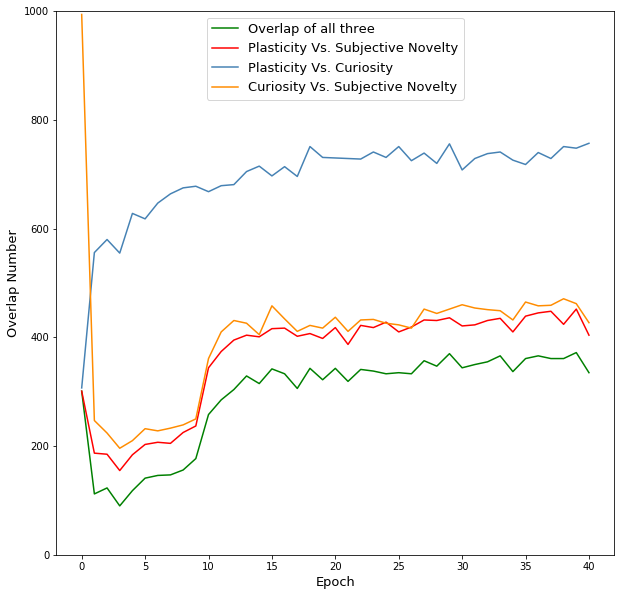

In [25]:
figure = plt.figure(figsize=[10,10])
figure.subplots_adjust(hspace=0.4, wspace=0.3)

plt.ylim(0,1000)

plt.plot(epochs, y['all'],
         label='Overlap of all three', color="Green", linewidth=1.5)
plt.plot(epochs, y['pl_sn'],
         label='Plasticity Vs. Subjective Novelty', color="red", linewidth=1.5)
plt.plot(epochs, y['pl_cu'],
         label='Plasticity Vs. Curiosity', color="steelblue", linewidth=1.5)
plt.plot(epochs, y['cu_sn'],
         label='Curiosity Vs. Subjective Novelty', color="darkorange", linewidth=1.5)

plt.legend(loc='upper center', fontsize=13)
plt.ylabel('Overlap Number', fontsize=13)
plt.xlabel('Epoch', fontsize=13)
plt.show()

In [27]:
figure.savefig('overlap_final.svg', bbox_inches='tight', format='svg')
figure.savefig('overlap_final.pdf', bbox_inches='tight', format='pdf')
figure.savefig('overlap_final.png', bbox_inches='tight', format='png', dpi = 300)

In [28]:
y['pl_cu']

[307,
 556,
 580,
 555,
 628,
 618,
 647,
 664,
 675,
 678,
 668,
 679,
 681,
 705,
 715,
 697,
 714,
 696,
 751,
 731,
 730,
 729,
 728,
 741,
 731,
 751,
 725,
 739,
 720,
 756,
 708,
 729,
 738,
 741,
 726,
 718,
 740,
 729,
 751,
 748,
 757]

In [24]:
y['cu_sn']

[994,
 247,
 224,
 196,
 210,
 232,
 228,
 233,
 239,
 250,
 361,
 410,
 431,
 426,
 405,
 458,
 434,
 411,
 422,
 417,
 437,
 411,
 432,
 433,
 426,
 423,
 417,
 452,
 444,
 452,
 460,
 454,
 451,
 449,
 432,
 465,
 458,
 459,
 471,
 462,
 427]

In [17]:
min(y['all'])

157

In [23]:
y['pl_sn']

[301,
 187,
 185,
 155,
 184,
 203,
 207,
 205,
 225,
 237,
 344,
 374,
 395,
 404,
 401,
 416,
 417,
 402,
 407,
 398,
 418,
 387,
 422,
 418,
 428,
 410,
 419,
 432,
 431,
 436,
 421,
 423,
 431,
 435,
 410,
 439,
 445,
 448,
 424,
 452,
 404]

#### Normalization

In [37]:
[((x-min(y['pl_sn']))*40/(max(y['pl_sn'])-min(y['pl_sn'])))+1 for x in y['pl_sn']]

[20.663299663299664,
 5.30976430976431,
 5.040404040404041,
 1.0,
 4.905723905723906,
 7.4646464646464645,
 8.003367003367003,
 7.734006734006734,
 10.427609427609427,
 12.043771043771043,
 26.454545454545453,
 30.494949494949495,
 33.323232323232325,
 34.535353535353536,
 34.13131313131313,
 36.15151515151515,
 36.28619528619529,
 34.26599326599327,
 34.93939393939394,
 33.72727272727273,
 36.42087542087542,
 32.245791245791246,
 36.95959595959596,
 36.42087542087542,
 37.76767676767677,
 35.343434343434346,
 36.55555555555556,
 38.30639730639731,
 38.17171717171717,
 38.84511784511785,
 36.82491582491583,
 37.0942760942761,
 38.17171717171717,
 38.71043771043771,
 35.343434343434346,
 39.24915824915825,
 40.05723905723906,
 40.46127946127946,
 37.22895622895623,
 41.0,
 34.535353535353536]